# Information Theory project

Cose da **capire**:
- Finire autotuning
- Calcolare ESS per altre funzioni
- Implementare NUTS con NumPyro/PyMC
- Debugging di b_squared (si riempie la memoria)
- Implementare altre funzioni

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import torch
import time

In [3]:
debug = False

def checkpoint(message = "", debug=True):
    if debug: print(message)
def warning(message = ""):
    print("WARNING: "+ message)

In [4]:
def choose_device():
  if torch.cuda.is_available():
      device = torch.device("cuda")
      #print('GPU available')
  else:
      device = torch.device("cpu")
      #print('GPU not available')
  return device

Let's first define the target distributions and the function used to compute the gradient of the loglikelihood:

In [5]:
def standard_cauchy(x):
    """
    This function takes an array of d-dimensional points as input
        x = [x_1, x_2, ..., x_d]

    For each point x_i, it computes the value of the cauchy distribution as:
        p(x_i) = ( 1/(1+x_{i,1}**2) )*( 1/(1+x_{i,2}**2) )*...*( 1/(1+x_{i,d}**2) )

    The output is a tensor containing the values of the distribution for each point.
    """
    # serve che sia tensore di torch per implementazione del gradiente
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32)
    if x.dim() == 1:
        x = x.unsqueeze(1)
    return torch.prod(1 / (np.pi * (1 + x**2)), axis=1)

In [6]:
def grad_log_likelihood(x, fn):
    """
    This function takes an array of d-dimensional points as input
        x = [x_1, x_2, ..., x_d]     with x_i  in R^d
    and a function fn that takes this array as argument.

    Then, computes the gradient (vector of the partial derivatives) of the loglikelihood
    of this function and evaluates it on each of the points in x
    """
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, requires_grad=True, dtype=torch.float32)
    x = x.detach().requires_grad_() # Returns a new Tensor, detached from the current graph
    L = -torch.log(fn(x))
    L.sum().backward() # with this command it calculates the gradients of L with respect to x and stores them in x.grad

    nablaL = x.grad
    x.grad = None # clears the gradient
    return nablaL

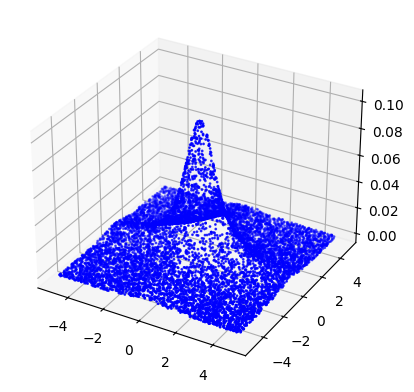

In [7]:
# standard cauchy in 2D
x = np.random.uniform(low=-5, high=5, size=(10000, 2))

ax = plt.axes(projection='3d')
ax.scatter(x[:,0], x[:,1], standard_cauchy(x).numpy(), c='blue', s=1)
plt.show()

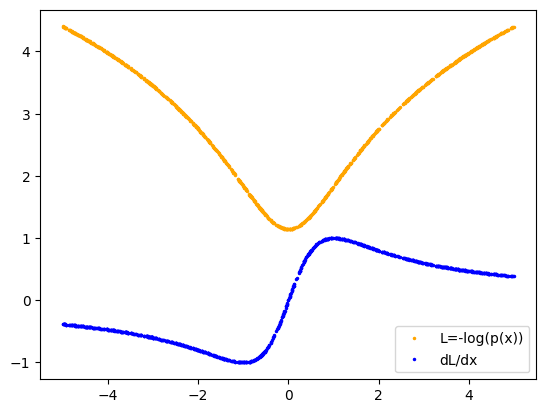

In [8]:
# standard cauchy in 1D
x = np.random.uniform(low=-5, high=5, size=(1000, 1)) # 1000 one-dimensional points
L = -np.log(standard_cauchy(x).detach().numpy()) # the function whose gradient we want to compute: -loglikelihood of the 1d cauchy distribution
nablaL = grad_log_likelihood(x, standard_cauchy).numpy()

plt.plot(x, L, 'o', color='orange', markersize=1.5, label='L=-log(p(x))')
plt.plot(x, nablaL, 'o', color='blue', markersize=1.5, label='dL/dx')
plt.legend()
plt.show()

-------------------------
Let's now define all the maps used to update position and momentum:

In [9]:
def position_update_map(x: np.ndarray, u: np.ndarray, w: float, epsilon: float) -> tuple:
    new_x = x + epsilon * u
    new_u = u
    new_w = w
    return new_x, new_u, new_w

def momentum_update_map(x: np.ndarray, u: np.ndarray, w: float, epsilon: float, d: int, fn) -> tuple:
    nablaL = grad_log_likelihood(x, fn) # computing the gradient of the loglikelihood of the pdf fn
    delta = epsilon * torch.linalg.norm(nablaL) / d
    e = - nablaL / torch.linalg.norm(nablaL)

    # updating position
    new_x = x

    # updating momentum
    prod = torch.dot(e,u)
    s = torch.sinh(delta)
    c = torch.cosh(delta)
    new_u = (u + e * (s + prod * (c - 1)))/(c + prod * s)
    #new_u /= np.linalg.norm(new_u)

    # updating weight
    new_w = w * (c + prod * s)
    return new_x, new_u, new_w

def stochastic_update_map(x: np.ndarray, u: np.ndarray, w: float, epsilon: float, L, d: int, fn) -> tuple:
    nu = np.sqrt((np.e**(2*epsilon/L)-1)/d)

    # updating position
    new_x = x

    # updating momentum
    device = choose_device()
    z = torch.normal(0, 1, size=(d,)).to(device)
    new_u = u + nu * z
    new_u /= torch.linalg.norm(new_u)

    # updating weight
    new_w = w

    return new_x, new_u, new_w

Let's define the leapfrog and minimal norm integration schemes:

In [10]:
def leapfrog(x: np.ndarray, u: np.ndarray, w: float, epsilon: float, d: int, fn) -> tuple:

    # Update momentum by half step
    x, u, w = momentum_update_map(x, u, w, epsilon/2, d, fn)

    # Update position by one step
    x, u, w = position_update_map(x, u, w, epsilon)

    # Update momentum by half step
    x, u, w = momentum_update_map(x, u, w, epsilon/2, d, fn)

    return x, u, w

def minimal_norm(x: np.ndarray, u: np.ndarray, w: float, epsilon: float, d: int, fn) -> tuple:

    l = 0.19318

    x, u, w = momentum_update_map(x, u, w, l*epsilon, d, fn)
    x, u, w = position_update_map(x, u, w, epsilon/2)
    x, u, w = momentum_update_map(x, u, w, epsilon*(1-2*l), d, fn)
    x, u, w = position_update_map(x, u, w, epsilon/2)
    x, u, w = momentum_update_map(x, u, w, epsilon*l, d, fn)

    return x, u, w

We now define some functions to track the energy and the ESS at every step.

The energy can be calculated via the hamiltonian $\rightarrow E=H(x, u)$ or via $w = \exp [(E-\mathcal{L}(x))/d] \rightarrow E=d\log w + \mathcal{L}(x)$.

In [11]:
def energy(x, w, d, fn):
    """
    This function computes the energy of the system
    """
    L = -torch.log(fn(x)).sum() # Negative log posterior
    E = d * torch.log(w) + L
    return E

The effective samples size can be obtained in different ways.

In [62]:
def effective_sample_size(X, d, cauchy=False, debug=False, autotune_mode=False):
    """
    This function computes the ESS used to evaluate the sampling algorithm used. In this
    case we are considering the MCHMC with q=0.

    NOTE:
    -The cauchy distribution case is special. We do not compute b_2 but we compute
    a coefficient b_L, function of the coordinate and momentum of a given
    simulation step. This should decrease during evolution. As it reaches a
    threshold value computed from theory, the simulation is considered converged
    and the ESS can be computed.

    -d should be very large for the validity of the approximations from which the
    formula are derived
    -----------------------------------------------------------------------------
    Args:
        X: vector of points sampled with MCHMC
        d: dimension of the problem
        cauchy: if True, the ESS is caluculated for the cauchy distribution
        autotune_mode: if True, it returns a list with the n_eff^{i} values,
                    needed to tune the step length
    """
    convergence_reached = False
    if cauchy:
        def cauchy_1D(x_i):
            return 1/(np.pi*(1+x_i**2))

        # Retrieving the number of samples simulated
        n_samples = X.shape[0]

        # Computing and storing the expectation values of L over each dimension
        device = choose_device()
        E_sampler_values = torch.zeros(d, device=device)
        for dim in range(d):
            x_i = X[:,dim] # sampled points over a single dimension
            C_i = cauchy_1D(x_i)
            E_sampler_i = torch.mean(-torch.log(C_i))
            E_sampler_values[dim] = E_sampler_i

        # Constants
        E_truth = torch.tensor(  np.log(4*np.pi)  , device=device)  # from paper
        const =   torch.tensor( (np.pi**2) / 3    , device=device) # a generic constant

        if autotune_mode: # compute the n_eff_i values

            n_eff_i_values = const / (E_sampler_values-E_truth)**2 # CHECK: if it is okay
            #this should be a vector with all the n_{eff}^{i} values

            return n_eff_i_values


        else: # compute the ESS

            threshold = 0.0165 # from paper

            # Computing the value of b_L and checking for convergence
            b_squared = (1/d)*torch.sum((E_sampler_values-E_truth)**2)
            b = torch.sqrt(b_squared)

            # Computing the Effective Sample Size
            n_eff = ( const ) / b_squared
            ESS = n_eff / n_samples
            #checkpoint(f"\tb_L: {np.sqrt(b_L_squared)}, ESS: {ESS}", debug)

            if  b < threshold:
                convergence_reached = True

            return ESS, b_squared

    else:
        sys.exit("Distribution not implemented yet")

# Microcanonical Hamiltonian Monte Carlo

Let's now define the MCHMC steps:

In [69]:
def MCHMC_bounces(d, N, L, epsilon, fn, int_scheme=leapfrog, debug=False):
    """
    This function implements the MCHMC algorithm for the q=0 case with random momentum
    bounces every K steps.
    Args:
        d: dimension of the problem
        N: number of steps
        L: distance between momentum bounces
        epsilon: step size
        fn: function to sample from
    Output:
        X: positions during evolution
        E: energies during evolution
        ESS: effective sample sizes during evolution
        b_squared: values useful for one figure of the paper

    """
    device = choose_device()

    K = int(L // epsilon) #  steps between bounces

    # Defining tensors where to store results of evolution
    X = torch.zeros((N+1, d), device=device)
    E = torch.zeros(N+1)
    B_squared = torch.zeros(N+1)

    # STEP 0: Intial conditions
    x = np.random.uniform(low=-2, high=2, size=(d,)) # Sample initial position x_o in R^d from prior
    x = torch.tensor(x, dtype=torch.float32, device=device)
    x.requires_grad_()

    u = torch.randn(d, device=device) # Sample initial direction of momentum u_0 from isotropic distribution in R^d
    u /= torch.linalg.norm(u)

    w = 1 # Set the intial weight
    w = torch.tensor(w, requires_grad=False, dtype=torch.float32, device=device)

    checkpoint(f"Step {0} (initialization):", debug)
    #checkpoint(f"\tx = {x}\n\tu = {u}\n\tw = {w}", debug)

    X[0] = x
    E[0] = energy(x, w, d, fn)
    ESS, b_squared = effective_sample_size(X, d, cauchy=True, debug=debug)
    B_squared[0] = b_squared

    #if d < 100:
    #    warning(f"For the validity of ESS results d should be very large but I am using d={d}")
    #warning("Check that X has not been flatten")

    start = time.time()
    # EVOLUTION: Algorithm implementation
    for n in range(1,N+1):

        checkpoint(f"Step {n}:", debug)

        # if K steps have been done, apply a bounce
        if n % K == 0:
          u = torch.randn(d, device=device)
          u /= torch.linalg.norm(u)

        # Updating coordinate and momentum
        x, u, w = int_scheme(x, u, w, epsilon, d, fn)
        #checkpoint(f"\tx = {x}\n\tu = {u}\n\tw = {w}", debug)

        '''
        if not np.isclose(np.linalg.norm(u), 1.0, atol=1e-4):
            sys.exit(f"Vector u should be normalized, while its norm is {np.linalg.norm(u)}.")
        '''

        # Storing results
        X[n] = x
        E[n] = energy(x, w,d, fn)
        ESS, b_squared = effective_sample_size(X, d, cauchy=True, debug=debug) #compute it after determine the new points in phase space
        B_squared[n] = b_squared

        inter_time = time.time()
        checkpoint(f"\t{inter_time-start} s", debug=debug)

    return X, E, ESS, B_squared

--------------------
Here we set the parameters and run the MCHMC algorithm:

In [18]:
# ALGORITHM PARAMETERS
d = 1000  # dimension of the problem
N = 10000 # number of steps
epsilon = 0.1 # step size
L = 1 # distance between momentum bounces
K = int(L//epsilon) #  steps between bounces

checkpoint(f"Number of steps N = {N}")
checkpoint(f"Steps between bounces K = {K}")
checkpoint(f"Number of bounces: {int(N//K)}")

Number of steps N = 10000
Steps between bounces K = 9
Number of bounces: 1111


In [65]:
debug = True
X, E, ESS, B_squared = MCHMC_bounces(d, N, L, epsilon, standard_cauchy, leapfrog, debug=debug)
print("end")

HELLO: True
Step 0 (initialization):
Step 1:
	0.20024919509887695 s
Step 2:
	0.42402005195617676 s
Step 3:
	0.6832771301269531 s
Step 4:
	0.9667866230010986 s
Step 5:
	1.202477216720581 s
Step 6:
	1.3619434833526611 s
Step 7:
	1.5388448238372803 s
Step 8:
	1.702385663986206 s
Step 9:
	1.8749494552612305 s
Step 10:
	2.0591440200805664 s
Step 11:
	2.2263967990875244 s
Step 12:
	2.3948557376861572 s
Step 13:
	2.560197591781616 s
Step 14:
	2.72050404548645 s
Step 15:
	2.887941837310791 s
Step 16:
	3.073498010635376 s
Step 17:
	3.2359769344329834 s
Step 18:
	3.3970608711242676 s
Step 19:


KeyboardInterrupt: 

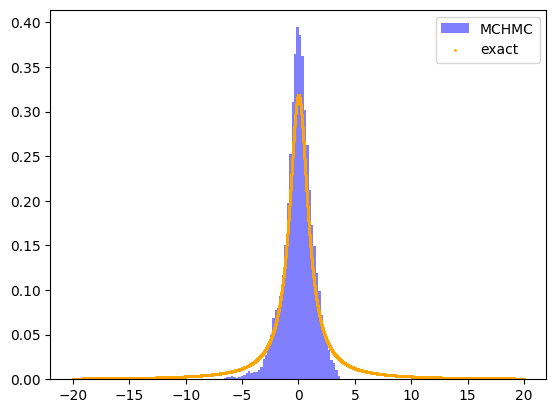

In [ ]:
X = X.flatten().to("cpu").detach().numpy()
x = np.linspace(-20, 20, 10000)
plt.hist(X, density=True, alpha=0.5, bins=50, color='blue', label='MCHMC')
plt.scatter(x, standard_cauchy(x).numpy(), color='orange', s=1, label='exact')
plt.legend()
plt.show()

In [ ]:
print(ESS)

tensor(0.0005, device='cuda:0', grad_fn=<DivBackward0>)


# Microcanonical Langevin-like Monte Carlo algorithm

Let's now define the Langevin HMC steps:

In [ ]:
def MCLMC(d, N, L, epsilon, fn, int_scheme=leapfrog, debug=False):

    device = choose_device()
    X = torch.zeros((N+1, d), device=device)
    E = torch.zeros(N+1)

    # STEP 0: Intial conditions
    x = np.random.uniform(low=-2, high=2, size=(d,)) # Sample initial position x_o in R^d from prior
    x = torch.tensor(x, dtype=torch.float32, device=device)
    x.requires_grad_()

    u = torch.randn(d, device=device) # Sample initial direction of momentum u_0 from isotropic distribution in R^d
    u /= torch.linalg.norm(u)

    w = 1 # Set the intial weight
    w = torch.tensor(w, requires_grad=False, dtype=torch.float32, device=device)

    checkpoint(f"Step {0} (initialization):", debug)
    checkpoint(f"\tx = {x}\n\tu = {u}\n\tw = {w}", debug)

    X[0] = x
    E[0] = energy(x, w, d, fn)
    ESS = effective_sample_size(X, d, cauchy=True, debug=debug)

    # EVOLUTION: Algorithm implementation
    for n in range(1,N+1):

        checkpoint(f"Step {n+1}:", debug)

        # Updating coordinate and momentum
        x, u, w = int_scheme(x, u, w, epsilon, d, fn)
        x, u, w = stochastic_update_map(x, u, w, epsilon, L, d, fn)

        '''
        if d<10:
            checkpoint(f"\tx = {x}\n\tu = {u}\n\tw = {w}", debug)
        if not np.isclose(np.linalg.norm(u), 1.0, atol=1e-4):
            sys.exit(f"Vector u should be normalized, while its norm is {np.linalg.norm(u)}.")
        '''

        # Storing results
        X[n] = x
        E[n] = energy(x, w,d, fn)
        ESS = effective_sample_size(X, d, cauchy=True, debug=debug)

    return X, E, ESS

In [ ]:
X, E, ESS = MCLMC(d, N, L, epsilon, standard_cauchy, minimal_norm, debug=debug)
print("end")

Output streaming troncato alle ultime 5000 righe.
GPU available
Step 8336:
GPU available
GPU available
Step 8337:
GPU available
GPU available
Step 8338:
GPU available
GPU available
Step 8339:
GPU available
GPU available
Step 8340:
GPU available
GPU available
Step 8341:
GPU available
GPU available
Step 8342:
GPU available
GPU available
Step 8343:
GPU available
GPU available
Step 8344:
GPU available
GPU available
Step 8345:
GPU available
GPU available
Step 8346:
GPU available
GPU available
Step 8347:
GPU available
GPU available
Step 8348:
GPU available
GPU available
Step 8349:
GPU available
GPU available
Step 8350:
GPU available
GPU available
Step 8351:
GPU available
GPU available
Step 8352:
GPU available
GPU available
Step 8353:
GPU available
GPU available
Step 8354:
GPU available
GPU available
Step 8355:
GPU available
GPU available
Step 8356:
GPU available
GPU available
Step 8357:
GPU available
GPU available
Step 8358:
GPU available
GPU available
Step 8359:
GPU available
GPU available


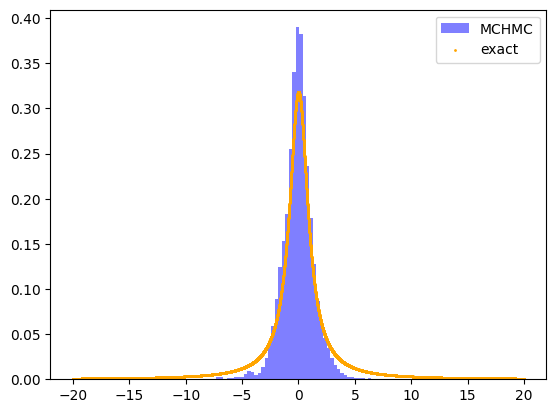

In [ ]:
X = X.flatten().to("cpu").detach().numpy()
x = np.linspace(-20, 20, 10000)
plt.hist(X, density=True, alpha=0.5, bins=50, color='blue', label='MCHMC')
plt.scatter(x, standard_cauchy(x).numpy(), color='orange', s=1, label='exact')
plt.legend()
plt.show()

In [ ]:
print(E)

tensor([193.9067, 193.9067, 193.9067,  ..., 193.8967, 193.8968, 193.8968],
       grad_fn=<CopySlices>)


# Hyperparameter tuning

## 1. Step size $\epsilon$
- Start with $\epsilon_0=0.5$ and run for $\mathcal{O}(100 \text{ steps})$
- Calculate $\text{Var}[E]$
- Update the step size $\epsilon_{i+1} = \epsilon_i(0.0005 d/\text{Var}[E])^{1/4}$
- Repeat until convergence

In [68]:
def tune_eps(d, L, fn, N, debug=False):
    checkpoint("Tuning epsilon..", debug=debug)
    checkpoint(f"\nParameters\n\td={d}\n\tL={L}\n\tNn={N}")
    epsilon = 0.5 # initial value
    checkpoint(f"Initial value: epsilon = {epsilon}")

    eps_arr = []
    #Change to an "until convergence" criterion, could track ((eps_i+1 - eps_i)/eps_i)^2 and get it lower
    #than a threshold
    checkpoint(f"\nRunning multiple iterations of MCHMC_bounces with {N} steps, updating epsilon")
    for i in range(10):
        checkpoint(f"\nIteration {i}")
        X, E, *_ = MCHMC_bounces(d, N, L, epsilon, fn, debug=False)
        checkpoint(f"X.shape: {X.shape}, E.shape: {E.shape}")
        varE = E.var()
        checkpoint(f"varE: {varE}")
        epsilon *= (0.0005 * d / varE)**(1/4)
        checkpoint(f"New epsilon: {epsilon}")
        eps_arr.append(epsilon)

    checkpoint(f"\tOptimized epsilon: {epsilon}")

    return np.array(eps_arr), X, E

## 2. Momentum decoherence scale $L$
#NOTE: NON--GAUSSIAN DISTRIBUTIONS
- After having tuned $\epsilon$ and estimated $\sigma_{eff}^2=\frac{1}{d}\sum_{i=1}^d \text{Var}[x_i^2]$
- Start with $L_0=\sigma_{eff}\sqrt{d}$
- Run for $n$ steps to estimate the effective sample size for each dimension (??)

We have by definition
$$
b_{\mathcal{L}}^2=\frac{\pi^2}{3 n_{eff}}
$$

$$
b_{\mathcal{L}}^2=
\frac{1}{d}\sum_{i=1}^{d}\Bigl(\mathbb{E}_{sampler}\bigl(-log(C(x_i))\bigr)-log(4\pi)\Bigr)^2   
=   
\frac{1}{d}\sum_{i=1}^{d}\biggl(\sum_{j=1}^{N}\Bigl(\frac{1}{\pi(1+x_{i,j}^2)}\Bigr)-log(4\pi)\biggr)^2
$$

Hypotesis:
$$
n_{eff}^{(i)}\equiv\frac{\pi^2}{3b_{\mathcal{L,i}}^2}
$$

$$
b_{\mathcal{L,i}}^2=\biggl(\sum_{j=1}^{N}\Bigl(\frac{1}{\pi(1+x_{i,j}^2)}\Bigr)-log(4\pi)\biggr)^2
$$

- Compute the decoherence scale as
$$L=0.4\dfrac{\epsilon}{d^{-1}\sum_{i=1}^d n_{eff}^{(i)}/n}$$

In [60]:
def s_eff(X):
  return np.sqrt((X**2).var(axis=0).mean())

def tune_L(d, sigma_ef, epsilon_optimized, N_prerun, fn, debug=False):
    checkpoint("\nTuning L..", debug=debug)
    #initial value
    L_init = sigma_ef * np.sqrt(d)

    # Run for n steps to estimate the effective sample size for each dimension
    X, *_ = MCHMC_bounces(d, N_prerun, L_init, epsilon_optimized, fn, debug=False)

    n_eff_values = effective_sample_size(X, d, cauchy=True, autotune_mode=True)

    # Computing the dechoerence scale L
    L = 0.4 * epsilon_optimized * d * N_prerun / (torch.sum(n_eff_values))
    checkpoint(f"\tOptimized L: {L}")
    return L

AUTOTUNING PROCESS:

In [ ]:
# Parameters used
checkpoint(f"d={d}")
L=10
N_prerun = 500

# Optimizing epsilon
eps, X, E = tune_eps(d, L, standard_cauchy, N_prerun, debug)
epsilon_opt = eps[-1]

sigma_eff = s_eff(X)
L_opt = tune_L(d, sigma_eff, epsilon_opt, N_prerun, standard_cauchy, debug)

d=1000
Tuning epsilon..

Parameters
	d=1000
	L=10
	Nn=500
Initial value: epsilon = 0.5

Running multiple iterations of MCHMC_bounces with 500 steps, updating epsilon

Iteration 0
